In [1]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import data_processing as dp
import model
import model_utilities as util
import vocab
import batch_samplers

In [3]:
import os

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

In [5]:
import importlib

In [6]:
importlib.reload(model)

<module 'model' from '/data/itasarom/diplom/gan_embeddings/GAN/model.py'>

In [7]:
def normalize_embeddings(embeddings):
    EPS = 1e-9
    mean = embeddings[1:].mean(axis=0, keepdims=True)
    se = (embeddings[1:].var(axis=0, keepdims=True)  + EPS )**0.5
#     embeddings
    embeddings = (embeddings - mean)/se
    embeddings[0, :] = 0
    return embeddings

In [8]:
vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='en', max_sent_length=100)
# vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='es', max_sent_length=100)
# vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='ru')
vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='es', max_sent_length=100)

In [9]:
# vocab1.embeddings.var(axis=0)

In [10]:
vocab1.embeddings = normalize_embeddings(vocab1.embeddings)
vocab2.embeddings = normalize_embeddings(vocab2.embeddings)

In [11]:
# vocab1.embeddings.var(axis=0)

In [12]:
len(vocab1.embeddings), len(vocab2.embeddings)

(50001, 50001)

In [13]:
len(sents1), len(sents2)

(17860, 18467)

In [14]:
torch.cuda.is_available()

True

In [17]:
sent_sampler_1 = batch_samplers.BatchSamplerRegularizer(sents=sents1, labels=labels1, vocab=vocab1, all_labels=all_labels, max_sent_length=None, seed=43)

In [18]:
sent_sampler_2 = batch_samplers.BatchSamplerRegularizer(sents=sents2, labels=labels2, vocab=vocab2, all_labels=all_labels, max_sent_length=None, seed=43)

In [19]:
print(len(sent_sampler_1.sents), len(sent_sampler_2.sents))

17860 18467


In [20]:
embed_sampler_1 = batch_samplers.BatchSamplerDiscriminator(vocab1)

In [21]:
embed_sampler_2 = batch_samplers.BatchSamplerDiscriminator(vocab2)

In [22]:
import IPython


In [23]:
sent_sampler_1.test[0][111]

['óscar',
 'miguel',
 'ares',
 '<pad>',
 'creates',
 'abstract',
 'and',
 'hard',
 'care',
 'home',
 'inspired',
 'by',
 'arid',
 'surroundings',
 'rows',
 'of',
 'concrete',
 'fins',
 'shade',
 'the',
 'large',
 'windows',
 'of',
 'this',
 'nursing',
 'home',
 'near',
 'the',
 'spanish',
 'city',
 'of',
 'valladolid',
 'which',
 'features',
 'rooms',
 'clustered',
 'around',
 'a',
 'landscaped',
 'central',
 'courtyard',
 'more',
 'spark',
 'designs',
 'model',
 'for',
 'asian',
 'retirement',
 'communities',
 'that',
 'double',
 'as',
 'city',
 'farms',
 'world',
 'architecture',
 'festival',
 '<pad>',
 'architecture',
 'firm',
 'spark',
 'has',
 'unveiled',
 'its',
 'concept',
 'for',
 'the',
 'next',
 'generation',
 'of',
 'retirement',
 'housing',
 'a',
 'community',
 'of',
 'homes',
 'and',
 'health',
 'facilities',
 'combined',
 'with',
 'a',
 'vertical',
 'urban',
 'farm',
 'slideshow',
 'more',
 'coconut',
 'groves',
 'surround',
 'brick',
 'retirement',
 'home',
 'on',
 'a',


In [24]:
sent_sampler_2.test[0][111]

['el',
 'piano',
 'oriental',
 'consagró',
 'a',
 'la',
 'franco',
 'libanesa',
 '<pad>',
 'abirached',
 'la',
 'novela',
 'gráfica',
 'cuenta',
 'la',
 'historia',
 'del',
 '<pad>',
 'de',
 'la',
 'autora',
 'creador',
 'de',
 'un',
 'piano',
 'bilingüe',
 'que',
 'unía',
 'la',
 'música',
 'de',
 'oriente',
 'y',
 'occidente']

In [25]:
cls = model.GAN(300, len(all_labels))

In [26]:
torch.cuda.current_device()

0

In [27]:
cls = cls.cuda()

In [28]:
trainer = util.Trainer(cls)

In [29]:
# params = {
#     'save_path': "./model_checkpoint.tc",
#     'save_every':10,
#     'sentence_iterations':200,
#     'discr_iterations':1,
#     'transform_iterations':500,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':128,
#     'n_discr_2':128,
#     'n_iter':20
    
# }

# params = {
#     'save_path': "./model_checkpoint.tc",
#     'save_every':10,
#     'sentence_iterations':2,
#     'discr_iterations':1,
#     'transform_iterations':5,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':128,
#     'n_discr_2':128,
#     'n_iter':20
    
# }

# params = {
#     'save_path': "./model_checkpoint_2_layers.tc",
#     'save_every':10,
#     'sentence_iterations':200,
#     'discr_iterations':10,
#     'transform_iterations':20,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':1024,
#     'n_discr_2':1024,
#     'n_iter':100
    
# }


params = {
    'save_path': "./model_checkpoint.tc",
    'save_every':10,
#     'sentence_iterations':0,
    'sentence_iterations':10,
    'discr_iterations':5,
     'transform_iterations':25,
#     'transform_iterations':25,
#     'n_sents_1':0,
#     'n_sents_2':0,
    'n_sents_1':256,
    'n_sents_2':256,
    'n_discr_1':1024,
    'n_discr_2':1024,
    'n_iter':1500,
    'validate_every':100
    
}

In [30]:
# !ls ../trained_models/10000_iterations_fr_en_big_embeddings

In [31]:
# trainer.restore("../trained_models/10000_iterations_fr_en_big_embeddings/model_checkpoint_sentences_fr_en_dropout_2.tc")
# cls.train()

In [32]:
# torch.abs(cls.transformation_1.bias - cls.transformation_2.bias).max()[0
# sents1[0]

In [33]:
# vocab1.embeddings[40]
# [k for k in vocab1.transformation if vocab1.transformation[k] == 40 ]

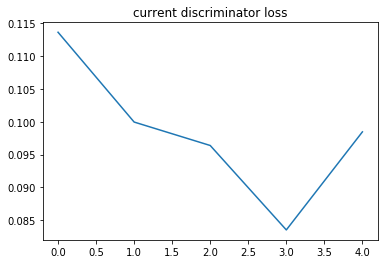

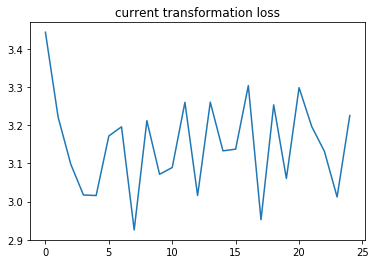

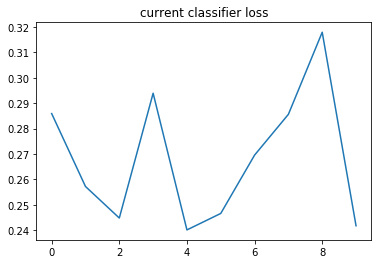

Iter 2999 class 0.26830488443374634, discr0.09838597476482391, transform 3.1482439041137695


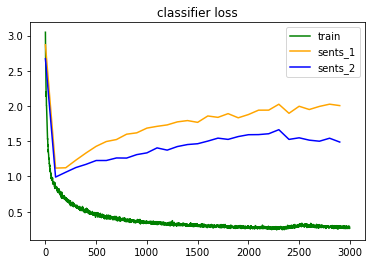

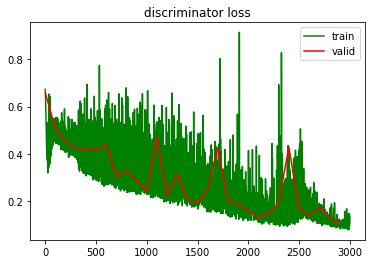

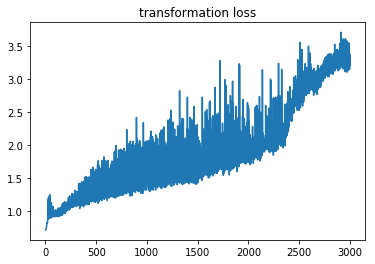

In [35]:
# trainer.t
trainer.train(sent_sampler_1, sent_sampler_2, embed_sampler_1, embed_sampler_2, params)

In [36]:
import pickle

In [37]:
trainer.model = None

In [38]:
pickle.dump((trainer, params), open("trainer.pkl", "wb"))

In [39]:
trainer.model = cls

In [116]:
# trainer = pickle.load(open("../trained_models/10000_iterations_fr_en_big_embeddings/trainer_10000_iterations_fr_en.pkl", "rb"))

In [117]:
w1 = cls.transformation_1.weight.data.cpu().numpy()

AttributeError: 'IdentityTransformation' object has no attribute 'weight'

In [118]:
!ls

1_with_classifier.pkl		model.py
__pycache__			model_checkpoint.tc
batch_samplers.py		model_checkpoint_sentences_2tc
data_processing.py		model_utilities.py
discriminator.py		model_utilities_rnn.py
discriminator_utilities.py	rnn_checkpoint.ckpt
embeds_1_tmp.vec		rnn_classifier.py
embeds_2_tmp.vec		rnn_classifier_dev_torch.ipynb
embeds_en.vec			rnn_classifier_torch.py
embeds_fr.vec			run_muse_validation.sh
evaluation.py			trainer.pkl
gan_debug.ipynb			validation.ipynb
gan_debug_neat.ipynb		vocab.py
gan_debug_with_sentences.ipynb	vocab_rnn.py


In [119]:
w2 = cls.transformation_2.weight.data.cpu().numpy()

In [120]:
np.all((w1.T @ w1).argmax(axis=1) == np.arange(w1.shape[0]))

NameError: name 'w1' is not defined

In [121]:
np.all((w2.T @ w2).argmax(axis=1) == np.arange(w2.shape[0]))

True

In [122]:
np.diag(w2 @ w2.T)

array([0.8386851 , 0.7254246 , 0.7472243 , 0.71764225, 0.8062274 ,
       0.69337565, 0.7251664 , 0.72920424, 0.7481885 , 0.6809194 ,
       0.7754728 , 0.7894641 , 0.7271444 , 0.66907424, 0.84073377,
       0.7899589 , 0.7944433 , 0.8714843 , 0.7994809 , 0.6893397 ,
       0.7837565 , 0.721682  , 0.7022327 , 0.8656708 , 0.64378154,
       0.82289845, 0.7461694 , 0.79007834, 0.72366273, 0.7657743 ,
       0.7520118 , 0.74419975, 0.8056714 , 0.730969  , 0.768219  ,
       0.8629956 , 0.7984717 , 0.69480056, 0.7877619 , 0.82538265,
       0.75267506, 0.80324537, 0.8131006 , 0.7943148 , 0.72378725,
       0.78566325, 0.8451788 , 0.807577  , 0.7853729 , 0.8258033 ,
       0.88435584, 0.7128113 , 0.86205447, 0.703209  , 0.7077934 ,
       0.6693371 , 0.7854175 , 0.7732366 , 0.79170245, 0.6655964 ,
       0.7126667 , 0.75795573, 0.78316134, 0.8359546 , 0.80318344,
       0.7638516 , 0.72224987, 0.6777144 , 0.8279714 , 0.9337039 ,
       0.8131435 , 0.78549755, 0.70497197, 0.7896966 , 0.78312

In [123]:
cls.discriminator.actual_model[0].bias.mean()

Variable containing:
-0.2340
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [124]:
# trainer.transformation_losses[-100:]

In [125]:
import sklearn
from sklearn.metrics import log_loss, accuracy_score

In [126]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [127]:
def get_probs(transformation, model, embeddings, batch_size, use_cuda):
    result = []
#     embed_sum = 0.0
#     squares_sum = 0.0
    embeds = []
    for position in range(0, len(embeddings), batch_size):
        x = embeddings[position:position + batch_size]
        x = torch.autograd.Variable(torch.from_numpy(x)).float()
        if use_cuda:
            x = x.cuda()
        
        x = transformation(x)
        _, probs = model.discriminator.forward(x)
        probs = probs.data.cpu().numpy()
        result.append(probs)
        
        x = x.cpu().data.numpy()
#         embed_sum += x
        embeds.append(x)
    
    result = np.vstack(result)
    z = 1 - result
    result = np.hstack([z, result])
    return result, np.vstack(embeds)

In [128]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [129]:
def validate(model, embeddings_1, embeddings_2, batch_size, use_cuda):
    probs_1, t1 = get_probs(model.transform1, model, embeddings_1, batch_size, use_cuda)
    probs_2, t2 = get_probs(model.transform2, model, embeddings_2, batch_size, use_cuda)
    probs = np.vstack([probs_1, probs_2])
    
    pred_1 = probs_1.argmax(axis=1).reshape(-1, 1)
    pred_2 = probs_2.argmax(axis=1).reshape(-1, 1)    
    pred = np.vstack([pred_1, pred_2])
    
    y_true = np.concatenate([np.zeros((len(pred_1),)), np.ones((len(pred_2)))])
    
    
    acc = accuracy_score(y_pred=pred, y_true=y_true)
    loss = log_loss(y_pred=probs, y_true=y_true)
    cm = build_confusion_matrix(probs, y_true)
    
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    
    plt.legend()
    plt.show()
    

    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    
    plt.legend()
    plt.show()
    
    t = np.vstack([t1, t2])
    
    return acc, loss, cm, probs, y_true , t
    

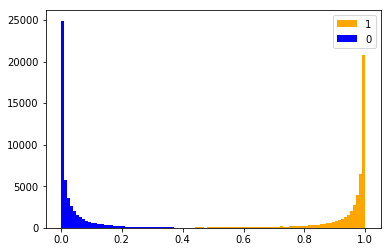

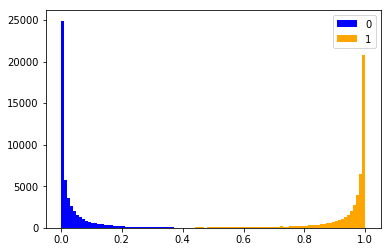

Accuracy  0.990690186196276
Loss  0.05787874123363975
Confusion matrix
 [[49827.   174.]
 [  757. 49244.]]
Min component variance 0.8167897462844849, median component variance 0.9028934240341187, mean component variance 0.9057457447052002, max c v 1.0165306329727173
Total length  100002


In [130]:
cls.eval()
result = validate(cls, vocab1.embeddings, vocab2.embeddings, 200, use_cuda=True)
print("Accuracy ", result[0])
print("Loss ", result[1])
print("Confusion matrix\n", result[2])
vars = result[-1].var(axis=0)
print("Min component variance {}, median component variance {}, mean component variance {}, max c v {}".format(
        min(vars), np.median(vars), np.mean(vars), max(vars)
    ))
print("Total length ", len(result[-1]))

In [131]:
# cls.discriminator.actual_model.zero_grad()

In [132]:
embeds = result[-1]

In [133]:
# embeds = normalize_embeddings(embeds)

In [134]:
embeds1 = embeds[:len(vocab1.embeddings)]
embeds2 = embeds[len(vocab1.embeddings):]

/data/itasarom/torch/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


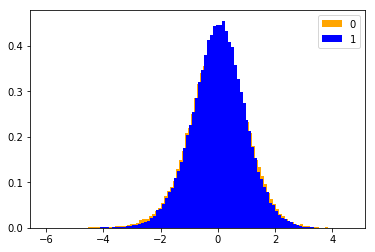

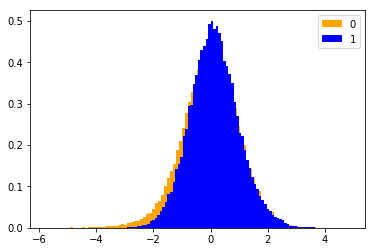

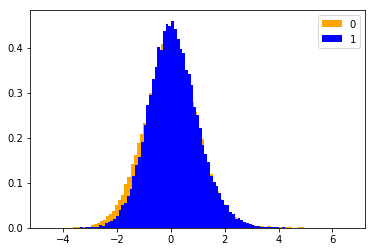

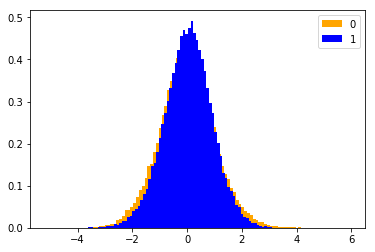

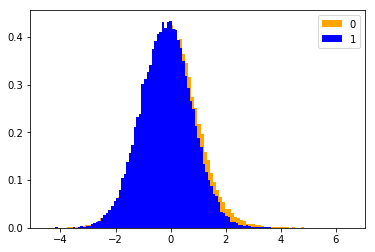

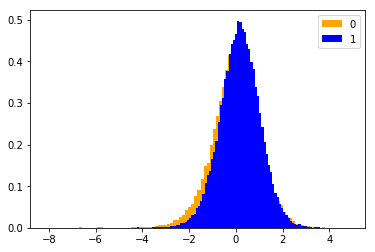

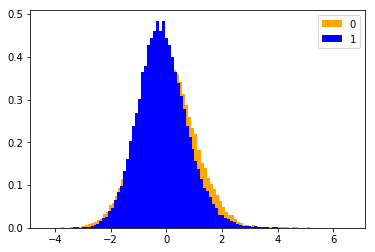

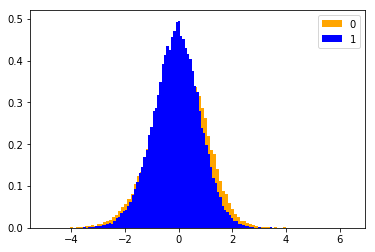

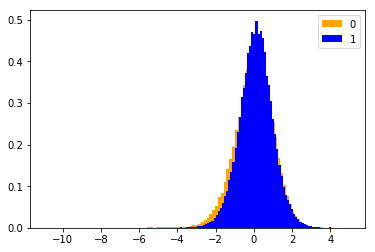

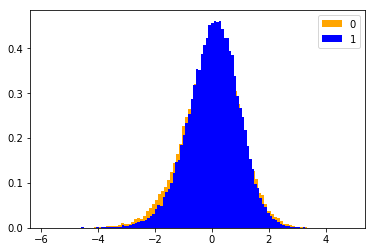

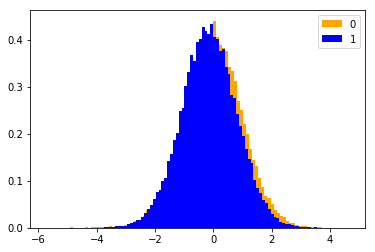

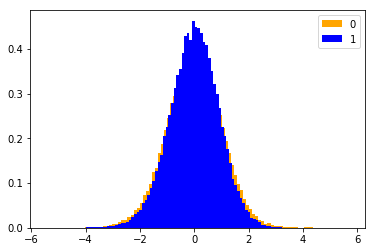

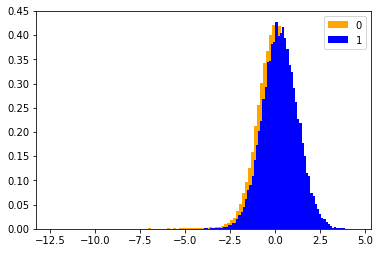

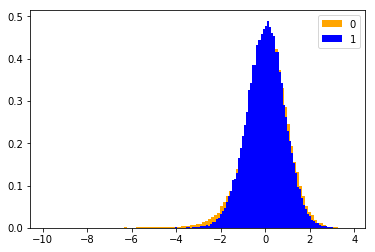

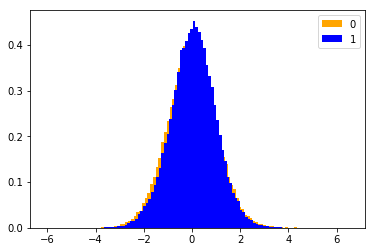

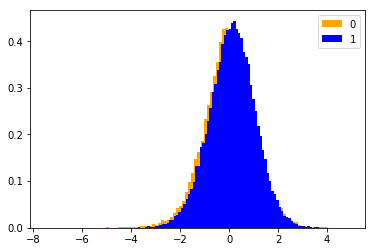

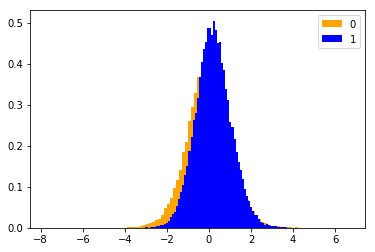

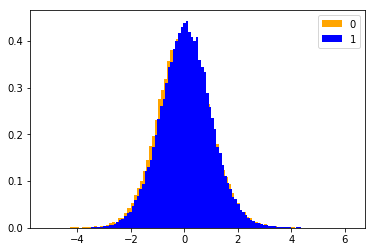

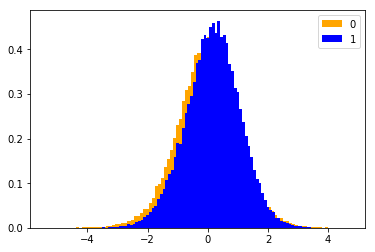

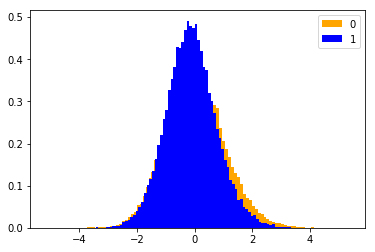

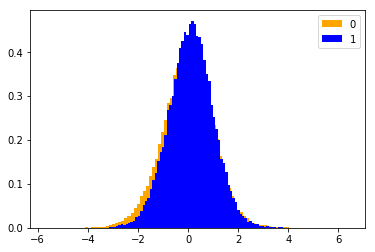

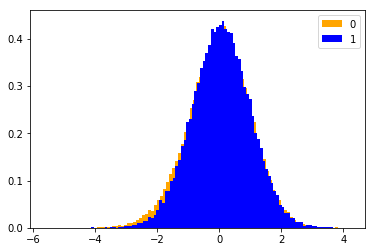

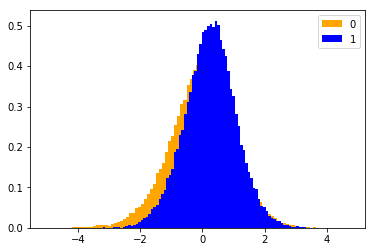

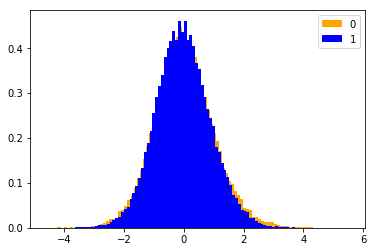

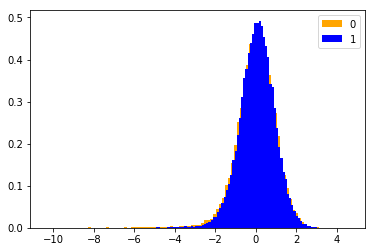

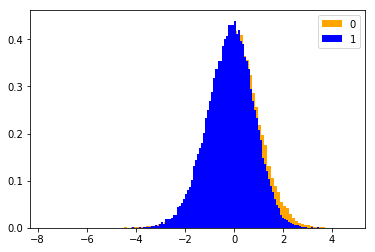

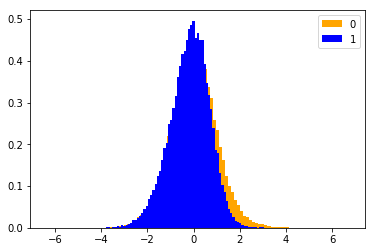

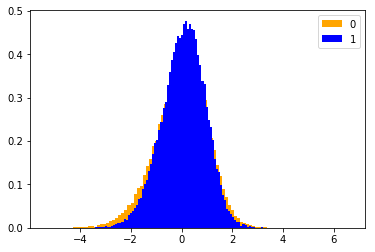

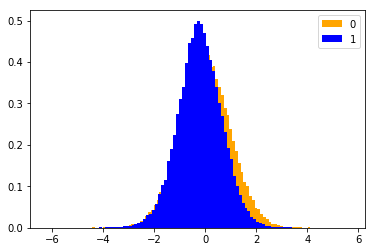

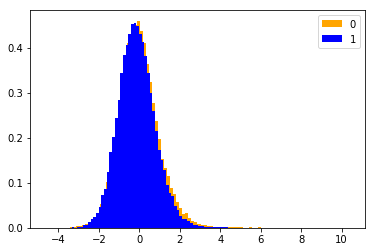

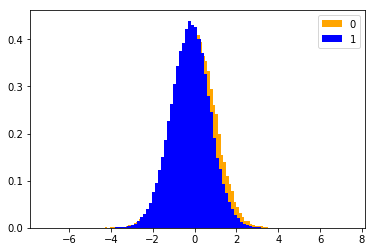

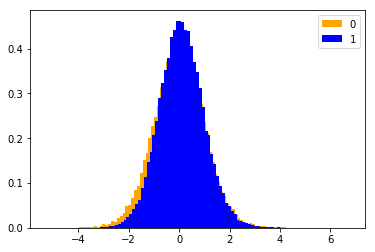

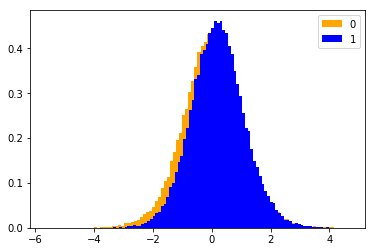

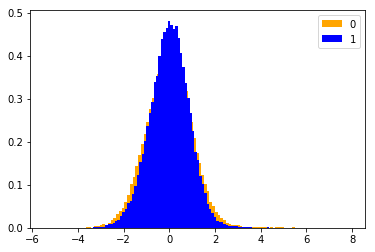

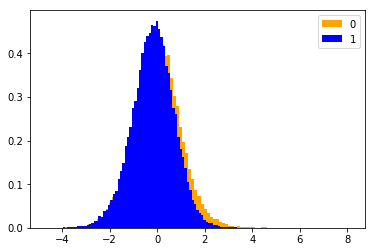

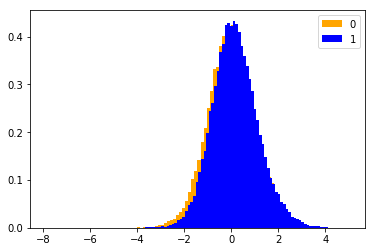

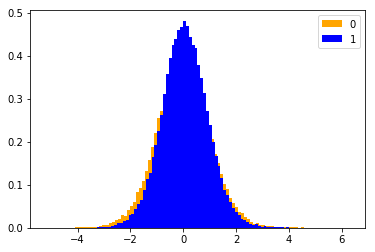

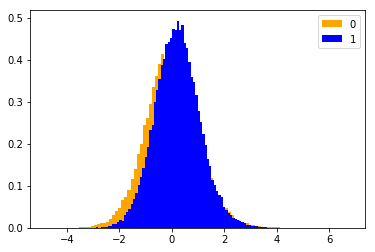

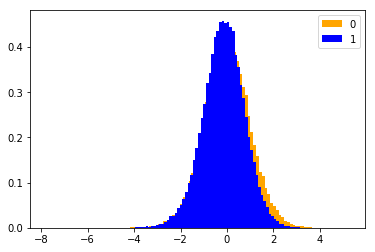

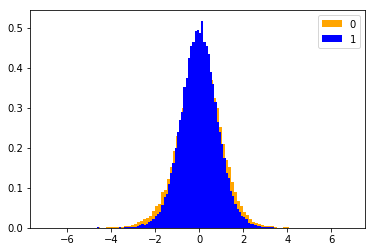

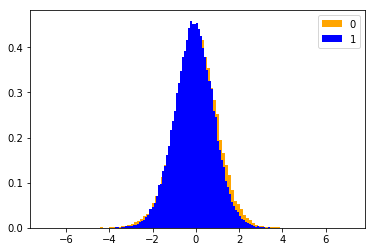

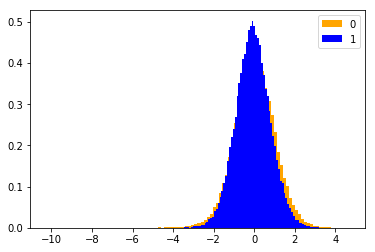

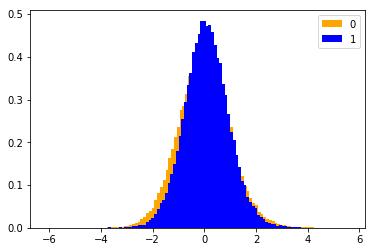

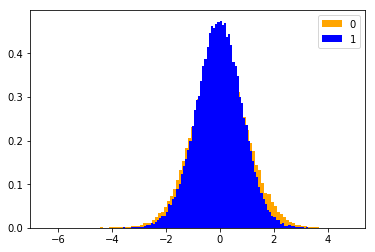

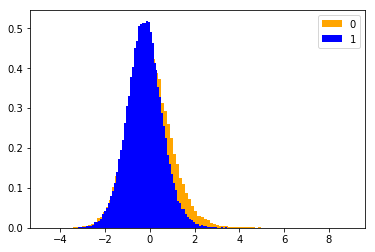

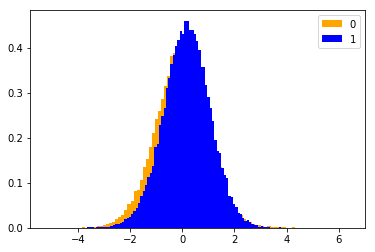

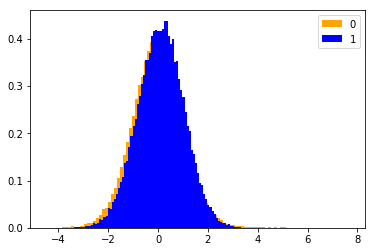

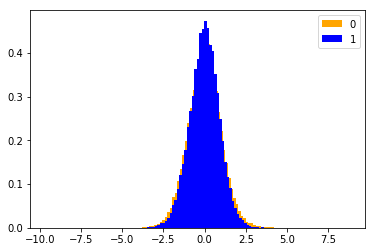

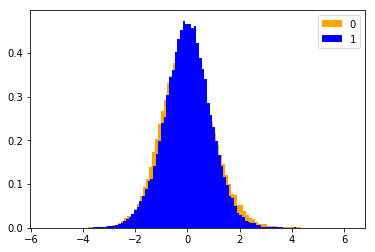

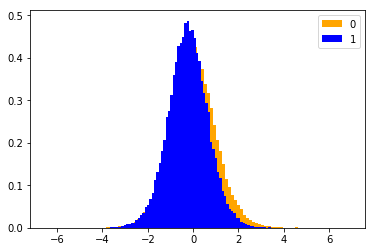

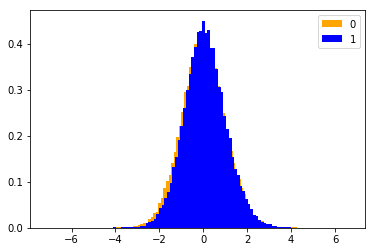

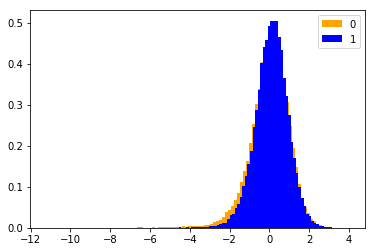

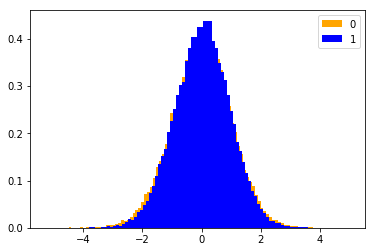

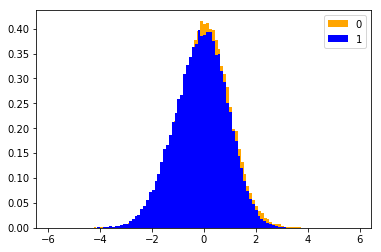

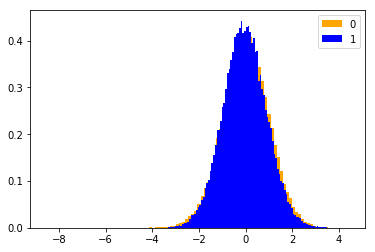

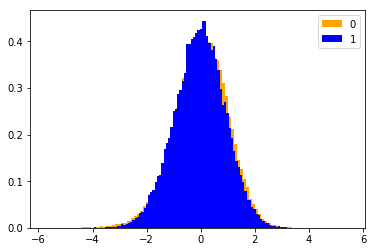

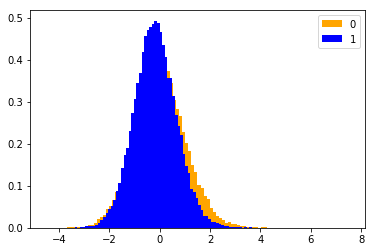

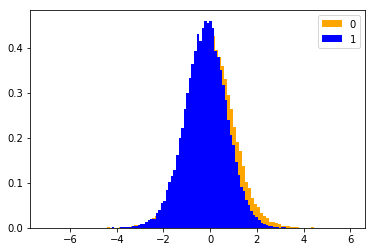

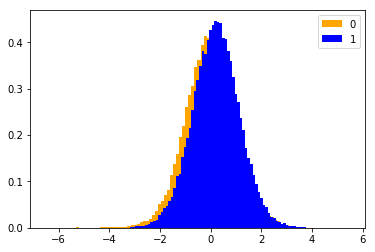

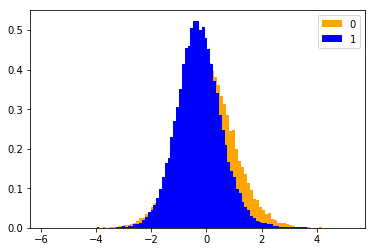

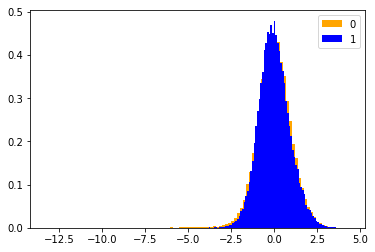

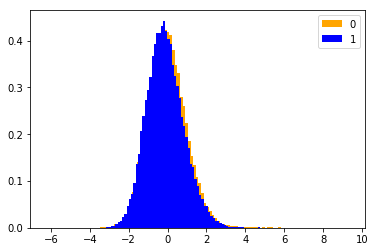

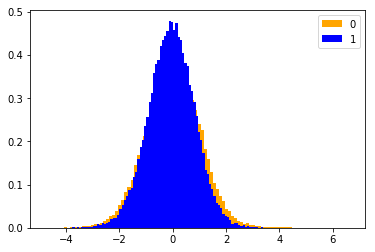

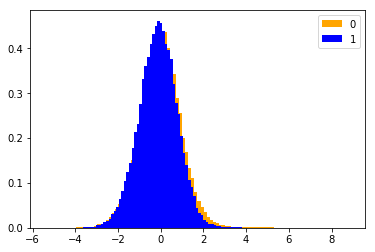

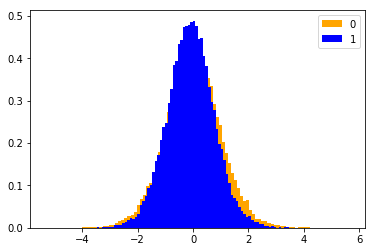

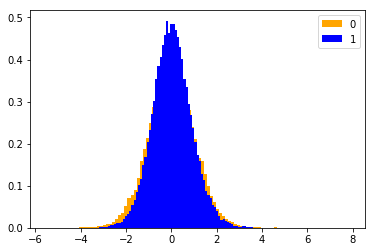

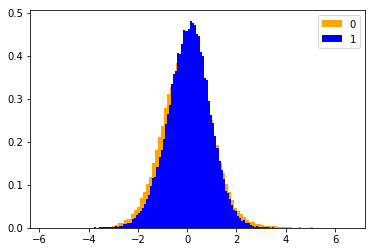

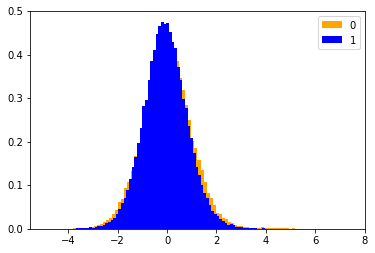

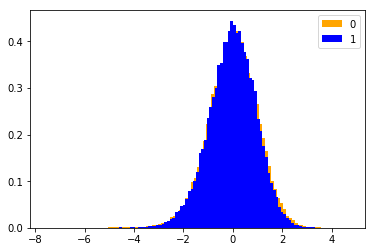

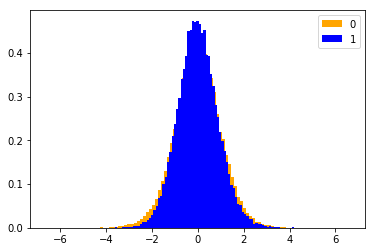

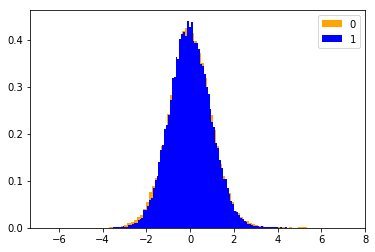

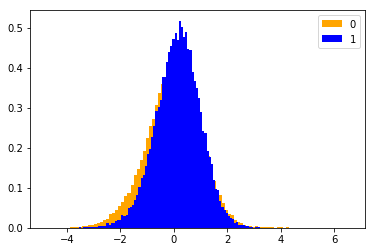

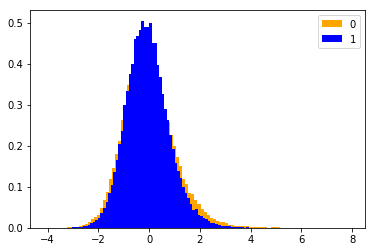

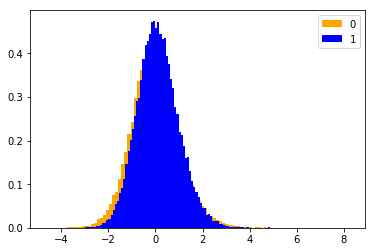

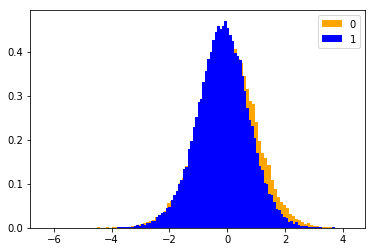

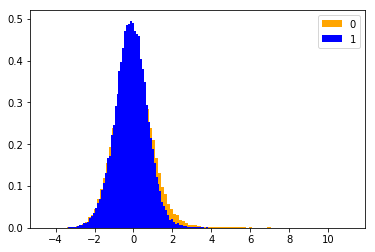

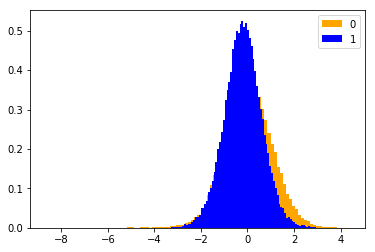

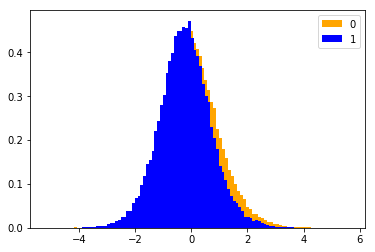

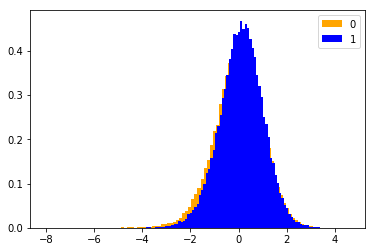

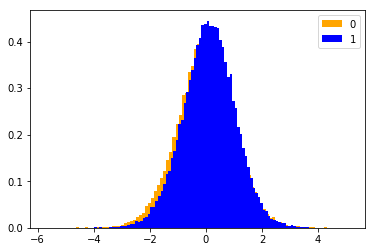

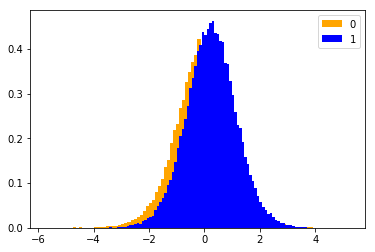

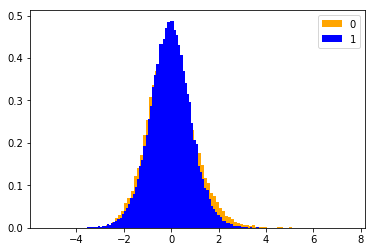

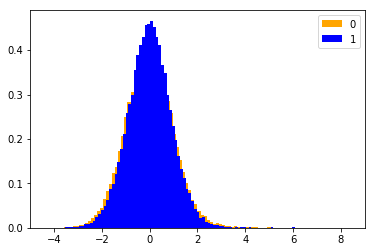

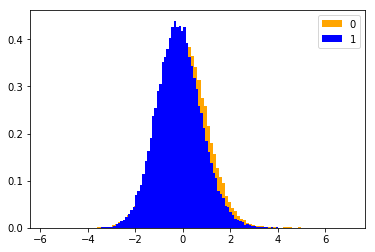

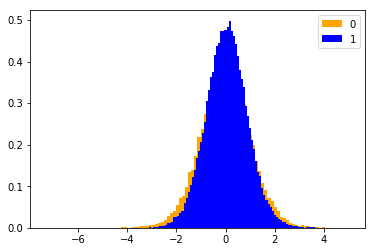

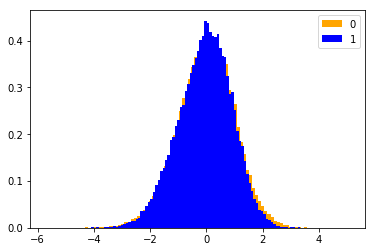

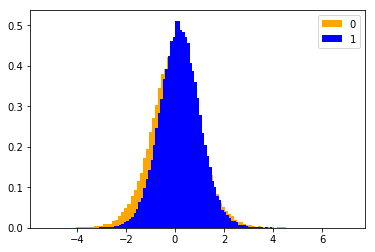

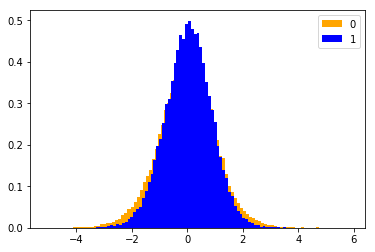

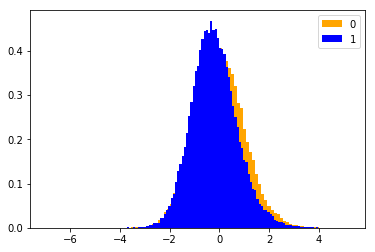

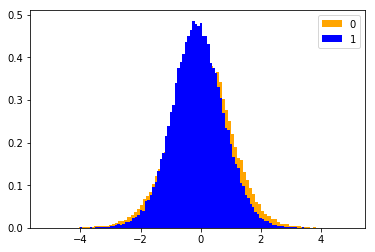

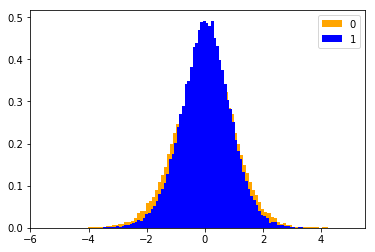

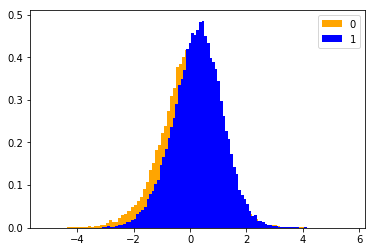

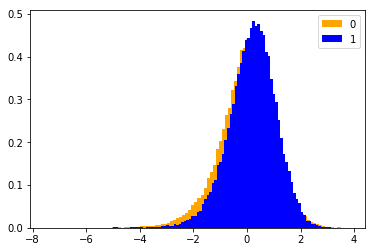

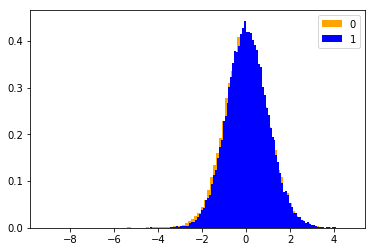

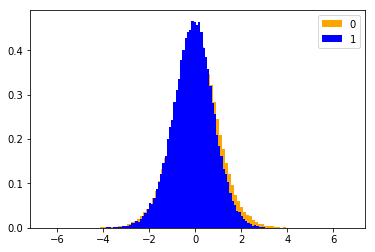

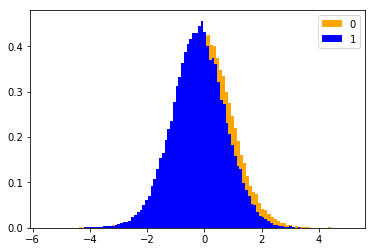

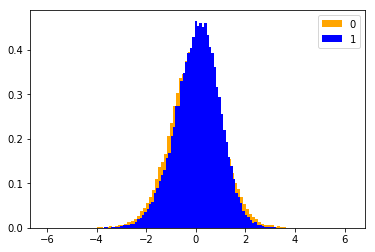

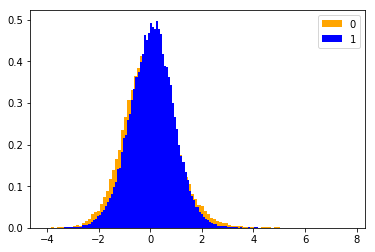

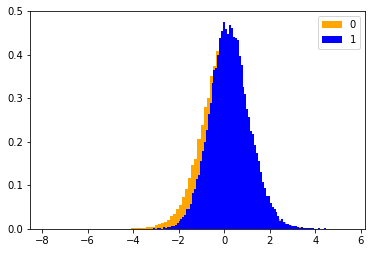

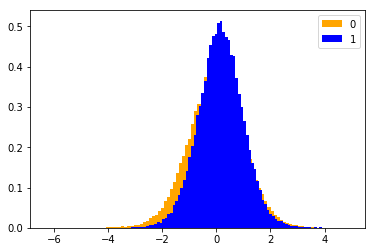

In [135]:
for i in range(100):
    plt.hist(embeds1[:, i], color='orange', bins=100, label='0', normed=True)
    plt.hist(embeds2[:, i], color='blue', bins=100, label='1', normed=True)
    plt.legend()
    plt.show()

In [136]:
import evaluation

In [137]:
def describe(sent_sampler, model, transformation):
    model.eval()
    x, mask, y = sent_sampler.get_test()
#     x, mask, y = sent_sampler.get_train_valid()
    true_y = np.zeros(shape=(len(y), len(sent_sampler.unique_labels)), dtype=np.int32)
    for idx, current_y in enumerate(y):
        true_y[idx, current_y] = 1
    
    x, mask, y = model.prepare_data_for_classifier(x, mask, y, transformation)
    
    if model.is_cuda:
        x = x.cuda()
        y = y.cuda()
        mask = mask.cuda()
    

    
    loss = model.classifier.get_loss(x, mask, y).data.cpu().numpy()
    probs = model.classifier(x, mask)[1].data.cpu().numpy()
    
    pred = np.argmax(probs, axis=1)
    
    acc = evaluation.accuracy(predicted_probs=probs, true_y=true_y)
    prec = {}
    rec = {}
    for cls in range(true_y.shape[1]):
        prec[cls] = evaluation.precision_by_class(probs, true_y, cls)
        rec[cls] = evaluation.recall_by_class(probs, true_y, cls)
    
    return acc, prec, rec, evaluation.build_confusion_matrix(probs, true_y)

    

In [138]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, cls.transform1)

In [139]:
print(acc, len(sent_sampler_1.sents))

(711, 1024, 0.6943359375) 17860


In [140]:
print(acc, len(sent_sampler_1.sents))

(711, 1024, 0.6943359375) 17860


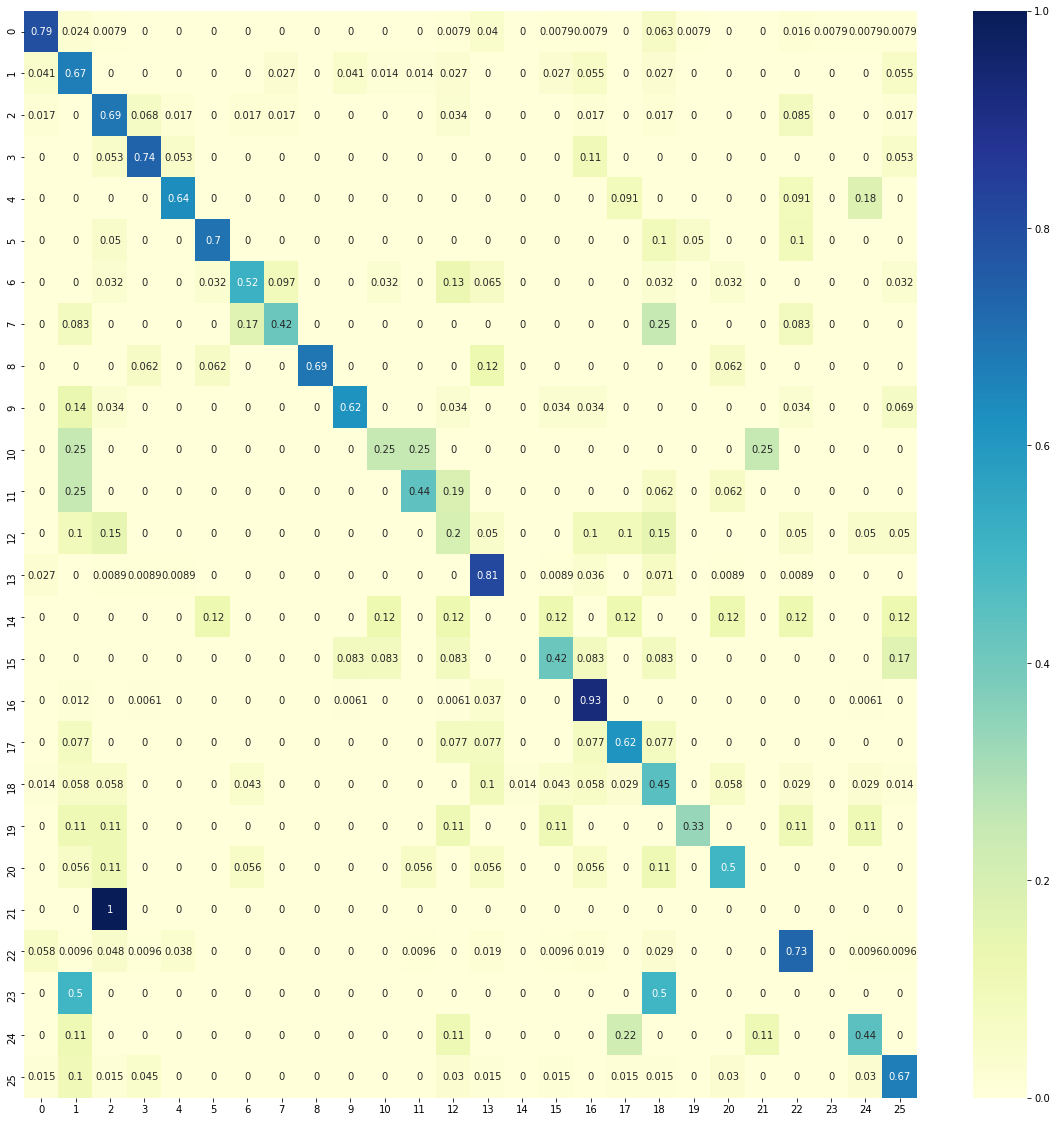

In [141]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [142]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_2, cls, cls.transform2)

In [143]:
print(acc, len(sent_sampler_2.sents))

(716, 1024, 0.69921875) 18467


In [144]:
print(acc, len(sent_sampler_2.sents))

(716, 1024, 0.69921875) 18467


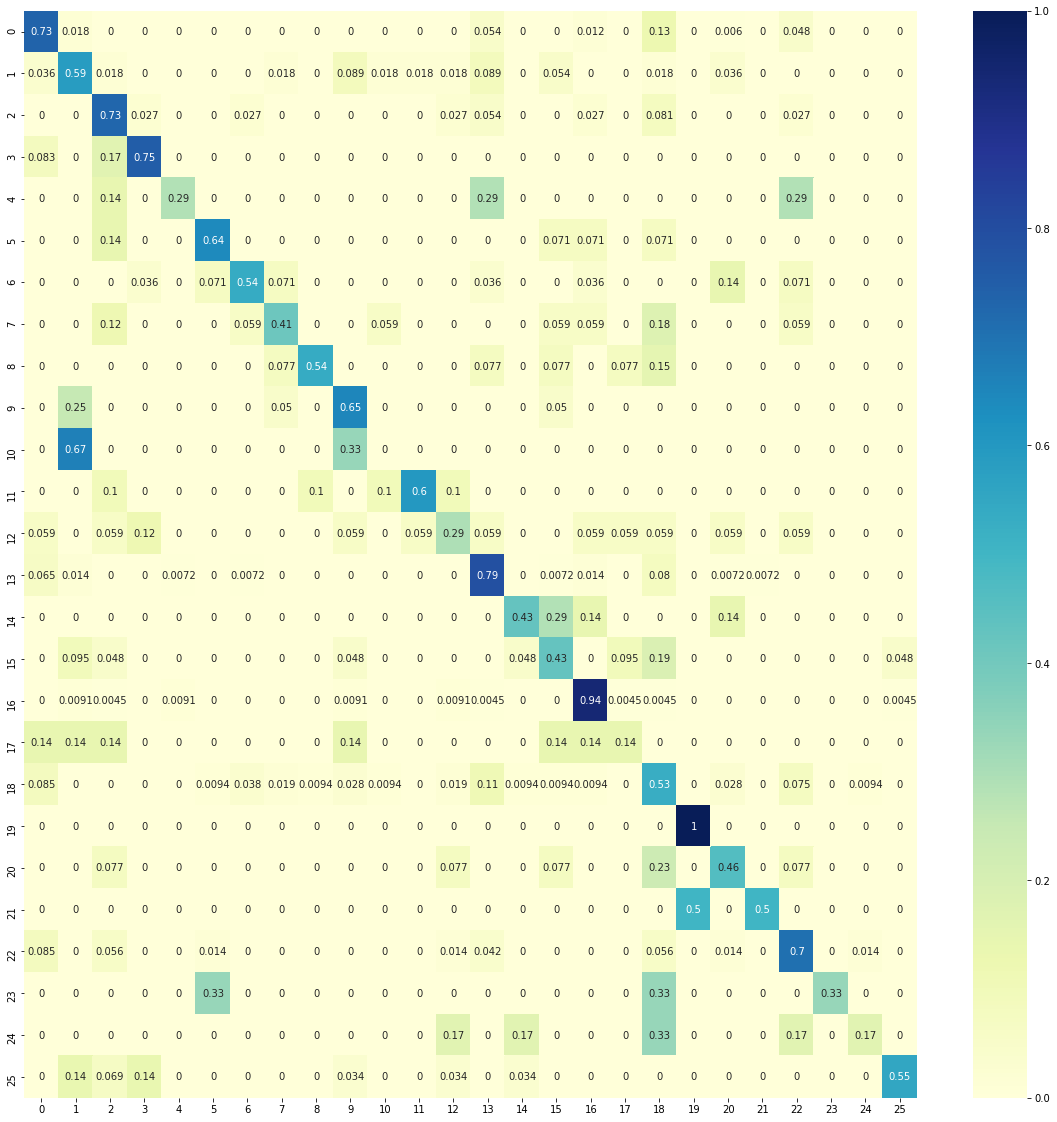

In [145]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [146]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, cls.transform2)

In [147]:
acc

(124, 1024, 0.12109375)

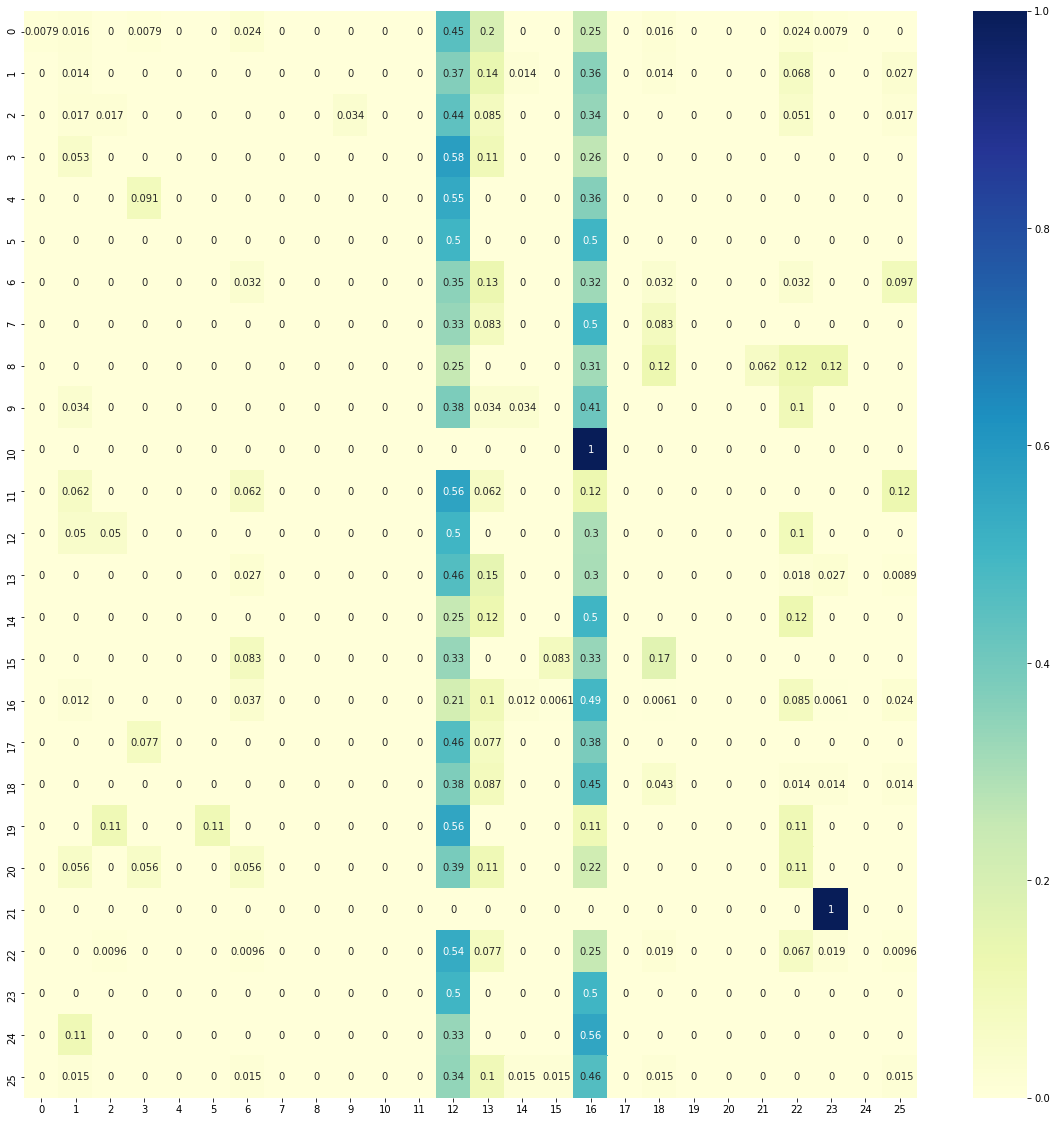

In [148]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [149]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, model.IdentityTransformation())

In [150]:
acc

(711, 1024, 0.6943359375)

In [151]:
f = """
aider
famille
groupe
regarder
posséder
président
haut
homme
venir
octobre
gros
chaque
chose
femme
trouver
publique
campagne
eau
gauche
bien
pays
jamais
"""
f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [152]:
s ="""
ayudar
familia
grupo
mira
poseer
presidente
alto
hombre
venir
octubre
grande
cada
cosa
mujer
encontrar
público
campaña
agua
izquierda
bueno
país
nunca
"""

f = [w.strip() for w in s.split("\n") if len(w) > 1]


s = """
help
family
group
look
own
president
high
man
come
october
big
every
thing
woman
find
public
campaign
water
left
good
country
never
"""
s = [w.strip() for w in s.split("\n") if len(w) > 1]

In [153]:
s, f = f, s

In [154]:
# def plot_word_by_id(t1, t2, e, f, ids, dims):
#     plt.figure(figsize=(20, 20))
# #     plt.scatter(t1[ids, 0], t1[ids, 1], color='r')
# #     plt.scatter(t2[ids, 0], t2[ids, 1], color='b')
#     plt.xlim(-3, 3)
#     plt.ylim(-3, 3)
#     for id in ids:
#         plt.annotate(e[id], (t1[id, dims[0]], t1[id, dims[1]]), color='r', fontsize=15)
#         plt.annotate(f[id], (t2[id, dims[0]], t2[id, dims[1]]), color='b', fontsize=15)
# #     plt.annotate(e)
# #         print(id)
#     plt.show()

In [155]:
def get_point(id, embeds, dims):
    return embeds[id, dims[0]], embeds[id, dims[1]]

def plot_word_by_id(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, dims, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        if not hide_original:
            plt.annotate(w1, get_point(id, orig1, dims), color='black', fontsize=15)
            plt.annotate(w2, get_point(id, orig2, dims), color='grey', fontsize=15)
        plt.annotate(w1, get_point(id, t1, dims), color='r', fontsize=15)
        plt.annotate(w2, get_point(id, t2, dims), color='b', fontsize=15)

        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [156]:
# plot_word_by_id(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, dims=[1, 2], hide_original=True)

In [157]:
# plot_word_by_id(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, dims=[12, 49], hide_original=True)

In [158]:
# e = """
# help
# family
# group
# look
# own
# president
# high
# man
# come
# october
# big
# every
# thing
# woman
# find
# public
# campaign
# water
# left
# good
# country
# never
# """
# e = [w.strip() for w in e.split("\n") if len(w) > 1]

In [159]:
# f = """
# aider
# famille
# groupe
# regarder
# posséder
# président
# haut
# homme
# venir
# octobre
# gros
# chaque
# chose
# femme
# trouver
# publique
# campagne
# eau
# gauche
# bien
# pays
# jamais
# """
# f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [160]:
# cls = cls.cpu()
from sklearn.decomposition import PCA

In [161]:
def get_point_pca(id, embeds):
    return embeds[id, 0], embeds[id, 1]

def plot_words_pca(pca, vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = pca.transform(orig1[ind_1])
    orig2 = pca.transform(orig2[ind_2])
    t1 = pca.transform(t1[ind_1])
    t2 = pca.transform(t2[ind_2])
    
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        
        if not hide_original:
            plt.annotate(w1, get_point_pca(id, orig1), color='black', fontsize=15)
            plt.annotate(w2, get_point_pca(id, orig2), color='grey', fontsize=15)
        plt.annotate(w1, get_point_pca(id, t1), color='r', fontsize=15)
        plt.annotate(w2, get_point_pca(id, t2), color='b', fontsize=15)
        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [162]:
# pca1 = PCA(n_components=2)
# pca1.fit(vocab1.embeddings)

In [163]:
# pca2 = PCA(n_components=2)
# pca2.fit(vocab2.embeddings)

In [164]:
# pca3 = PCA(n_components=2)
# pca3.fit(embeds1)

In [165]:
# pca4 = PCA(n_components=2)
# pca4.fit(embeds2)

In [166]:
pca = PCA(n_components=2)
# pca.fit(np.vstack([embeds1, embeds2]))
pca.fit(np.vstack([embeds2]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

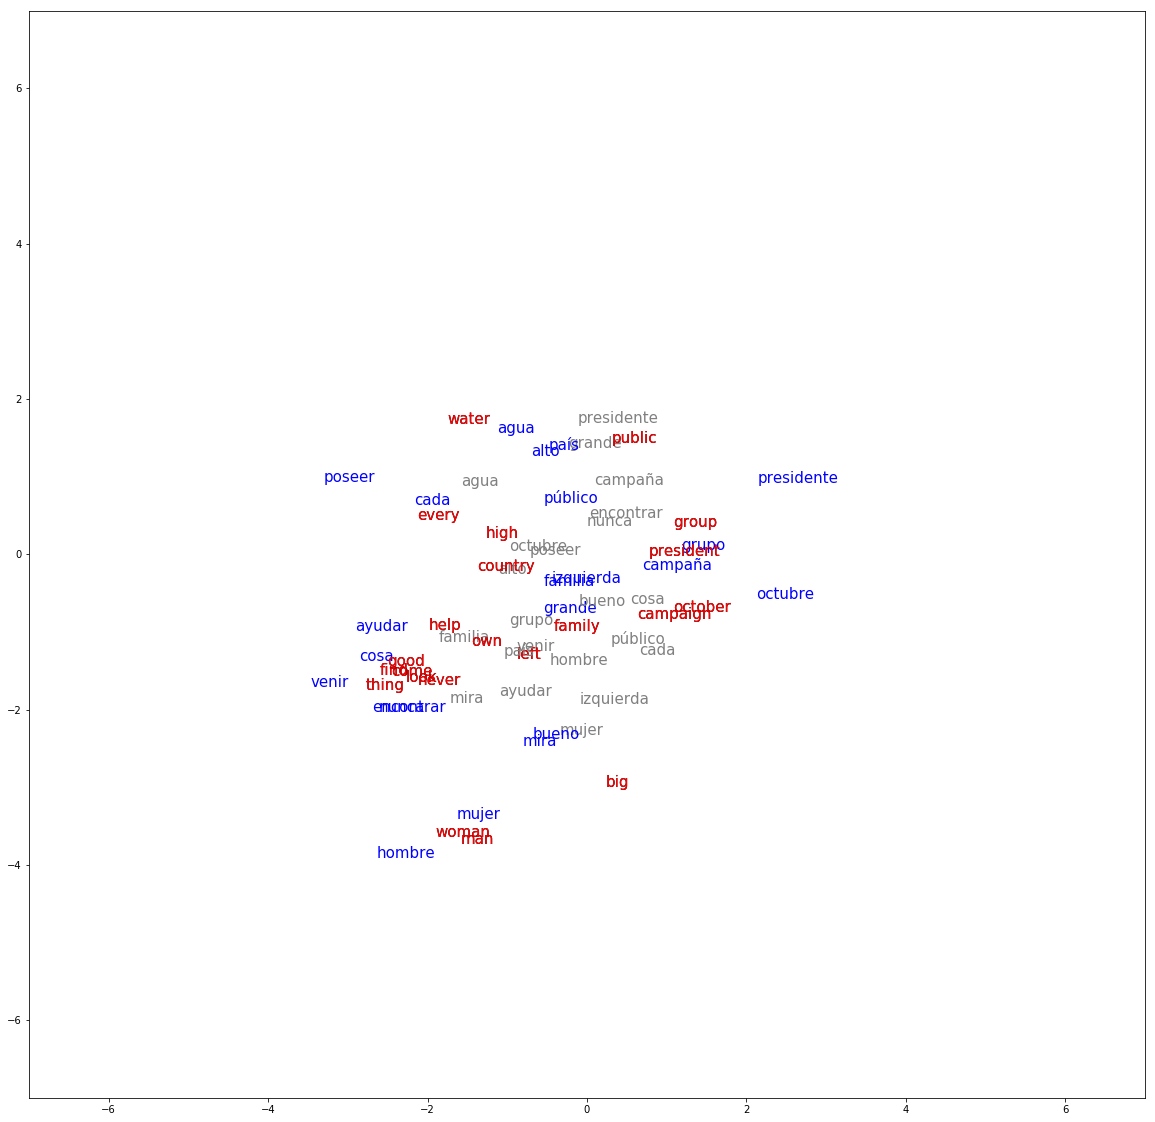

In [167]:
plot_words_pca(pca, vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, hide_original=False)

In [168]:
from sklearn.metrics.pairwise import cosine_similarity

In [169]:
import seaborn as sns

In [170]:
# f

In [171]:
def cos(a, b):
    a = a/(a**2).sum(axis=1, keepdims=True)**0.5
    b = b/(b**2).sum(axis=1, keepdims=True)**0.5
    
    return (a * b).sum(axis=1)

def cosine_metrics(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    before = cos(orig1, orig2)
    after = cos(t1, t2)
    
    print("{}|{}|{}|{}".format("lang1", "lang2", "before", "after", fill=' ', align='<', width=10))
    for w1, w2, c1, c2 in zip(lang_1, lang_2, before, after):
        print("{}|{}|{:.4f}|{:.4f}".format(w1, w2, c1, c2, fill=' ', align='<', width=10))
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    plt.figure(figsize=(15, 15))
    sns.heatmap(c1, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2 - c1)
    plt.show()
    
#     print(t1.shape, t2.shape)
#     print(c2.shape)
    s = 0
    for id, w1 in enumerate(lang_1):
#         print(c2[id].argmax())
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        s += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(s/len(lang_1))
#     plt.figure(figsize=(15, 15))
#     sns.heatmap((c2 - c1 > 0.1).astype(np.float32))
#     plt.show()
#     print(np.diag(c2))
#     print(np.diag(c1))
#     print()


In [172]:

def word_translation_cosine(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    
    count = 0
    for id, w1 in enumerate(lang_1):
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(count/len(lang_1))
    
    count = 0
    for id, w2 in enumerate(lang_2):
        translation = lang_1[c2[:, id].argmax()]
        if translation == lang_1[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_1[id]
        print("{} --> {} ({})".format(w2, translation, res))
        
    print(count/len(lang_2))



In [173]:
word_translation_cosine(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

help --> ayudar (OK)
family --> familia (OK)
group --> grupo (OK)
look --> encontrar (Fail)
own --> nunca (Fail)
president --> presidente (OK)
high --> alto (OK)
man --> hombre (OK)
come --> venir (OK)
october --> octubre (OK)
big --> grande (OK)
every --> cada (OK)
thing --> cosa (OK)
woman --> mujer (OK)
find --> encontrar (OK)
public --> público (OK)
campaign --> campaña (OK)
water --> agua (OK)
left --> izquierda (OK)
good --> bueno (OK)
country --> país (OK)
never --> nunca (OK)
0.9090909090909091
ayudar --> help (OK)
familia --> family (OK)
grupo --> group (OK)
mira --> look (OK)
poseer --> own (OK)
presidente --> president (OK)
alto --> high (OK)
hombre --> man (OK)
venir --> come (OK)
octubre --> october (OK)
grande --> big (OK)
cada --> every (OK)
cosa --> thing (OK)
mujer --> woman (OK)
encontrar --> find (OK)
público --> public (OK)
campaña --> campaign (OK)
agua --> water (OK)
izquierda --> left (OK)
bueno --> good (OK)
país --> country (OK)
nunca --> never (OK)
1.0


lang1|lang2|before|after
help|ayudar|0.0591|0.7158
family|familia|0.0183|0.6546
group|grupo|0.0535|0.6499
look|mira|0.0569|0.2476
own|poseer|0.0475|0.2165
president|presidente|-0.0324|0.5969
high|alto|0.0782|0.3724
man|hombre|-0.0778|0.5670
come|venir|0.0181|0.5076
october|octubre|0.0116|0.3832
big|grande|-0.0128|0.2766
every|cada|0.0074|0.4218
thing|cosa|-0.0033|0.4481
woman|mujer|0.1033|0.6438
find|encontrar|0.0524|0.6200
public|público|0.0790|0.4641
campaign|campaña|0.0652|0.6377
water|agua|0.0500|0.6500
left|izquierda|0.0386|0.3999
good|bueno|-0.0258|0.4034
country|país|0.0190|0.4564
never|nunca|-0.0212|0.5922


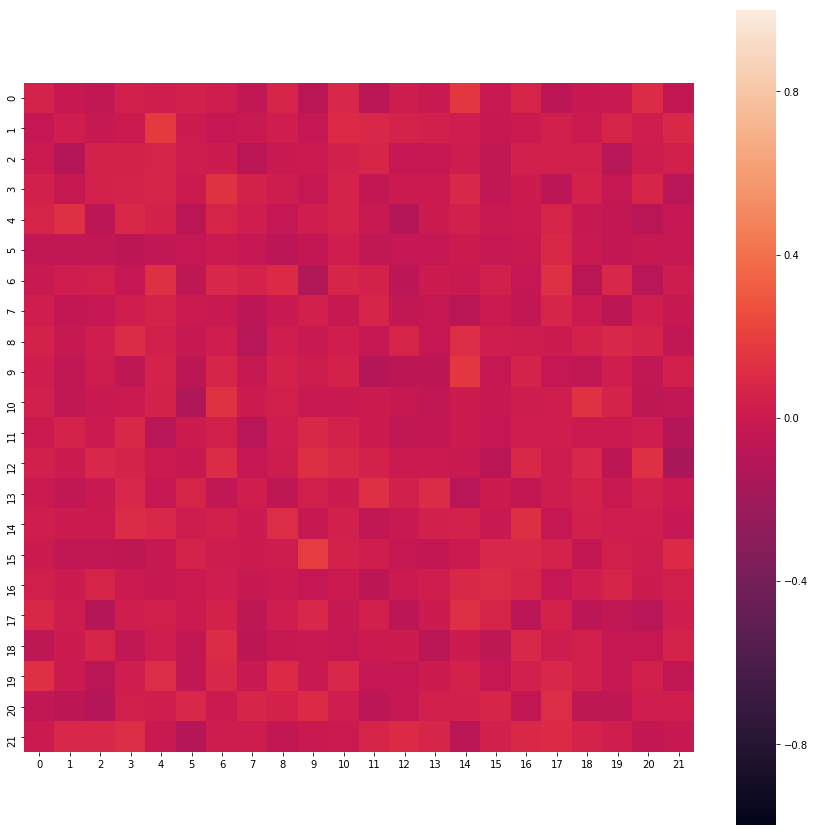

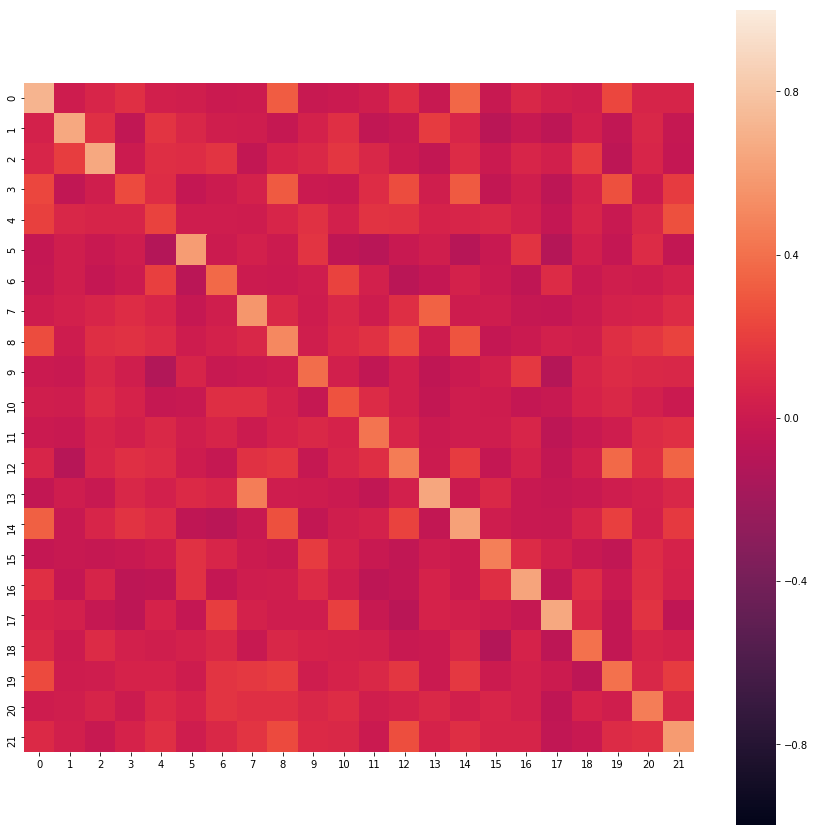

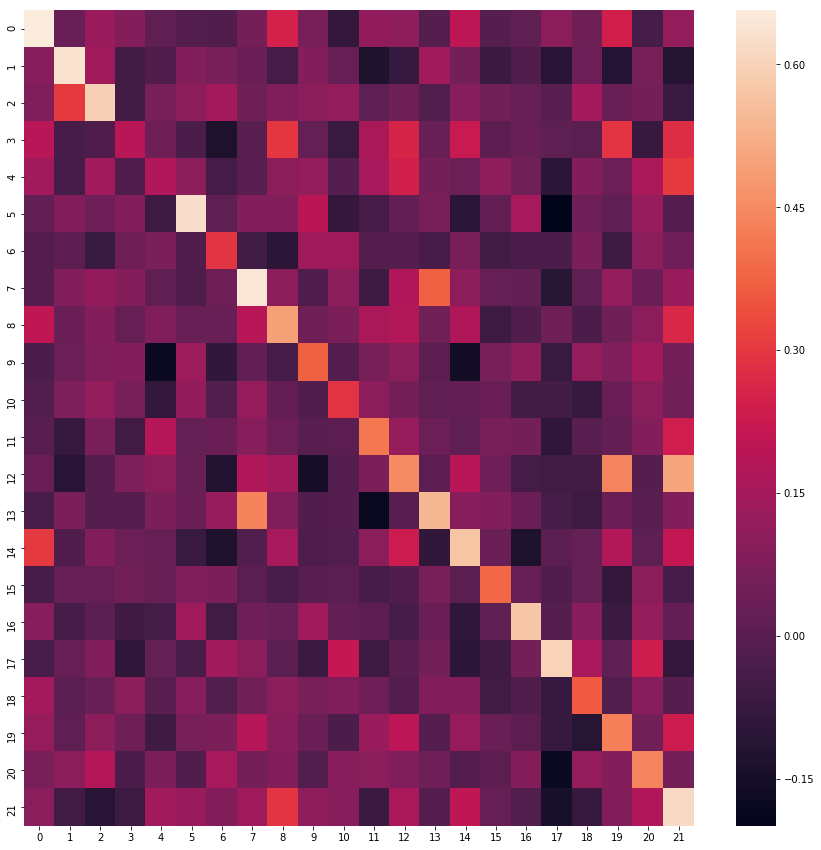

help --> ayudar (OK)
family --> familia (OK)
group --> grupo (OK)
look --> encontrar (Fail)
own --> nunca (Fail)
president --> presidente (OK)
high --> alto (OK)
man --> hombre (OK)
come --> venir (OK)
october --> octubre (OK)
big --> grande (OK)
every --> cada (OK)
thing --> cosa (OK)
woman --> mujer (OK)
find --> encontrar (OK)
public --> público (OK)
campaign --> campaña (OK)
water --> agua (OK)
left --> izquierda (OK)
good --> bueno (OK)
country --> país (OK)
never --> nunca (OK)
0.9090909090909091


In [174]:
cosine_metrics(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

In [175]:
# vocab1.transformation

In [176]:
import os
def read_facebook_dict(path, file_name, vocab1, vocab2):
    path = os.path.join(path, file_name)
    
    lang_1 = []
    lang_2 = []
    with open(path, "r") as f:
        for line in f:
            a, b = line.strip().split(" ")
            if a in vocab1.transformation and b in vocab2.transformation:
                lang_1.append(a)
                lang_2.append(b)
                
    return lang_1, lang_2

In [177]:
def word_translation_cosine_silent(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2,ks,  use_transformed=True,):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    if use_transformed:
        similarity = cosine_similarity(t1, t2)
    else:
        similarity = cosine_similarity(orig1, orig2)
        
    
    counts1 = {k:0 for k in ks}
    for id, w1 in enumerate(lang_1):
        candidate_ids = (-similarity[id]).argsort()
        for k in ks:
            if id in candidate_ids[:k]:
                counts1[k] += 1
        
    counts2 = {k:0 for k in ks}
    for id, w2 in enumerate(lang_2):
        candidate_ids = (-similarity[:, id]).argsort()
        for k in ks:
            if id in candidate_ids[:k]:
                counts2[k] += 1
        
#     res_for_lang_2 = count/len(lang_2)
    
#     return res_for_lang_1, res_for_lang_2
    for k in ks:
        counts1[k] /= len(lang_1)
        counts2[k] /= len(lang_2)
        
    return counts1, counts2


In [178]:
word_translation_cosine_silent(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500,1000, 2000])

({1: 0.9090909090909091,
  2: 0.9545454545454546,
  3: 0.9545454545454546,
  4: 0.9545454545454546,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: 1.0,
  9: 1.0,
  10: 1.0,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0},
 {1: 1.0,
  2: 1.0,
  3: 1.0,
  4: 1.0,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: 1.0,
  9: 1.0,
  10: 1.0,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0})

In [179]:
lang_1, lang_2 = read_facebook_dict("../crosslingual/dictionaries/", "en-es.5000-6500.txt", vocab1, vocab2)

In [180]:
# word_translation_cosine_silent(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500,1000, 2000])

In [181]:
def word_translation_cosine_complete(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2,ks,  use_transformed=True,):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    orig1_complete = orig1
    orig2_complete = orig2
    t1_complete = t1
    t2_complete = t2
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    if use_transformed:
        similarity_1_2 = cosine_similarity(t1, t2_complete)
        similarity_2_1 = cosine_similarity(t2, t1_complete)
    else:
        similarity_1_2 = cosine_similarity(orig1, orig2_complete)
        similarity_2_1 = cosine_similarity(orig2, orig1_complete)
        
    
    counts1 = {k:0 for k in ks}
    for id, w1 in enumerate(lang_1):
        translation_id = vocab2.words.index(lang_2[id])
        candidate_ids = (-similarity_1_2[id]).argsort()
        for k in ks:
            if translation_id in candidate_ids[:k]:
                counts1[k] += 1
        
    counts2 = {k:0 for k in ks}
    for id, w2 in enumerate(lang_2):
        translation_id = vocab1.words.index(lang_1[id])
        candidate_ids = (-similarity_2_1[id]).argsort()
        for k in ks:
            if translation_id in candidate_ids[:k]:
                counts2[k] += 1
        
#     res_for_lang_2 = count/len(lang_2)
    
#     return res_for_lang_1, res_for_lang_2
    for k in ks:
        counts1[k] /= len(lang_1)
        counts2[k] /= len(lang_2)
        
    return counts1, counts2


In [182]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=False)

({1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0003667033370003667,
  10: 0.0003667033370003667,
  50: 0.0007334066740007334,
  100: 0.0014668133480014668,
  200: 0.003667033370003667,
  500: 0.011001100110011002,
  1000: 0.019801980198019802,
  2000: 0.03667033370003667,
  5000: 0.09790979097909791,
  10000: 0.20095342867620095,
  20000: 0.40337367070040336,
  50000: 1.0},
 {1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  50: 0.0014668133480014668,
  100: 0.0018335166850018336,
  200: 0.003667033370003667,
  500: 0.010634396773010634,
  1000: 0.02016868353502017,
  2000: 0.03593692702603594,
  5000: 0.09424275760909424,
  10000: 0.20205353868720205,
  20000: 0.39897323065639895,
  50000: 1.0})

In [183]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=True)

({1: 0.3641364136413641,
  2: 0.5119178584525119,
  3: 0.5936927026035937,
  4: 0.6373303997066373,
  5: 0.6640997433076641,
  6: 0.6817015034836817,
  7: 0.6941694169416942,
  8: 0.7077374404107077,
  9: 0.7227722772277227,
  10: 0.7334066740007334,
  50: 0.8507517418408508,
  100: 0.8822882288228823,
  200: 0.907957462412908,
  500: 0.938027136046938,
  1000: 0.9607627429409608,
  2000: 0.973964063072974,
  5000: 0.9853318665199853,
  10000: 0.9937660432709937,
  20000: 0.9992665933259993,
  50000: 1.0},
 {1: 0.4239090575724239,
  2: 0.5247524752475248,
  3: 0.5782911624495783,
  4: 0.6134946828016135,
  5: 0.6395306197286396,
  6: 0.6611661166116611,
  7: 0.6743674367436744,
  8: 0.6879354602126879,
  9: 0.6985698569856986,
  10: 0.7077374404107077,
  50: 0.8298496516318299,
  100: 0.8621195452878622,
  200: 0.8958562522918958,
  500: 0.9314264759809314,
  1000: 0.9512284561789512,
  2000: 0.9691969196919692,
  5000: 0.984965163182985,
  10000: 0.9926659332599926,
  20000: 0.9985331

In [184]:
#dp.write_embeds("./embeds_fr.vec", embeds1, vocab1.words)

In [185]:
#dp.write_embeds("./embeds_en.vec", embeds2, vocab2.words)

In [186]:
s = """
january
february
march
april
may
june
july
august
september
october
november
december
"""
s = [w.strip() for w in s.split("\n") if len(w) > 1]

In [187]:
f = """
janvier
février
mars
avril
mai
juin
juillet
aout
septembre
octobre
novembre
décembre
"""
f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [188]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=True)

KeyError: 'janvier'

In [ ]:
word_translation_cosine(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

In [ ]:
plot_words_pca(pca, vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, hide_original=True)